In [1]:
import numpy as np
import pandas as pd
import pickle
from sentence_transformers import SentenceTransformer
from sys import getsizeof
import time

/Users/behzadshomali/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_table('../datasets/CheckThat_Lab/train_ml.tsv')
df = df.sample(n=df.shape[0], random_state=2000, replace=False).reset_index(drop=True)
df_train, df_dev = np.split(df, [int(.9*len(df))])

df_test = pd.read_table('../datasets/CheckThat_Lab/test_ml.tsv')
df_test = df_test.sample(n=df_test.shape[0], random_state=2000, replace=False).reset_index(drop=True)

In [3]:
print(df_train.shape)
print(df_dev.shape)
print(df_test.shape)

(5965, 3)
(663, 3)
(600, 2)


In [4]:
df.head()

,sentence_id,sentence,label
0,50f8b1cc-b96e-4845-a9fd-44b62a7e7863,"""Dat blijft bestaan, tot het wordt rechtgezet.""",OBJ
1,e59ab113-c755-4b55-9753-0a4e2a607500,"""Een samenleving waarin veel culturen samenlev...",OBJ
2,cd26b610-d10a-4059-adbe-d5382c7af8e7,Sul fronte opposto pare offuscata la posizione...,SUBJ
3,FAT_489-curl_03_007,كما يتم تنظيم المسيرات والمظاهرات أمام السفارا...,OBJ
4,8c880770-a393-4cc8-ba17-89cbf57432d0,"Denmark, Germany, and France have each seen 10...",OBJ


In [5]:
# Load the SBERT model
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

In [6]:
# X_train = model.encode(list(df_train.sentence))
# X_dev = model.encode(list(df_dev.sentence))

# y_train = df_train["label"]
# y_dev = df_dev["label"]

In [165]:
# save the embedding results
pickle.dump(X_train, open("./train_embeddings_fever.p","wb" ))
pickle.dump(X_dev, open("./dev_embeddings_fever.p", "wb"))

# save the labels
pickle.dump(y_train, open("./train_labels_fever.p", "wb"))
pickle.dump(y_dev, open("./dev_labels_fever.p", "wb"))

In [155]:
sizes = {}

In [159]:
### checkthat_lab ###
# X_train = pickle.load(open("./train_embeddings_originals.p", "rb"))
# X_dev = pickle.load(open("./dev_embeddings_originals.p", "rb"))

# y_train = pickle.load(open("./train_labels_originals.p", "rb"))
# y_dev = pickle.load(open("./dev_labels_originals.p", "rb"))


### aspect_sentiment ###
# df_train = pd.read_json('../datasets/Aspect_Sentiment/train.json', orient='index')
# df_train['polarity'] = df_train['polarity'].map({'positive': 1, 'negative': -1, 'neutral': 0})
# X_train = model.encode(list(df_train.sentence))
# y_train = df_train.polarity

# df_test = pd.read_json('../datasets/Aspect_Sentiment/test.json', orient='index')
# df_test['polarity'] = df_test['polarity'].map({'positive': 1, 'negative': -1, 'neutral': 0})
# X_dev = model.encode(list(df_test.sentence))
# y_dev = df_test.polarity


### FEVER ###
df_train = pd.read_csv('../datasets/FEVER/Train.csv')
df_train['label'] = df_train['label'].map({'SUPPORTS': 1, 'REFUTES': -1, 'NOT ENOUGH INFO': 0})
X_train = model.encode(list(df_train.claim))
y_train = df_train.label

df_test = pd.read_csv('../datasets/FEVER/Test.csv')
df_test['label'] = df_test['label'].map({'SUPPORTS': 1, 'REFUTES': -1, 'NOT ENOUGH INFO': 0})
X_dev = model.encode(list(df_test.claim))
y_dev = df_test.label

sizes['Original'] = X_train.nbytes

In [151]:
df_train.head()

,id,verifiable,label,claim,evidence
0,75397,VERIFIABLE,SUPPORTS,Nikolaj Coster-Waldau worked with the Fox Broa...,"[[[92206, 104971, 'Nikolaj_Coster-Waldau', 7],..."
1,150448,VERIFIABLE,SUPPORTS,Roman Atwood is a content creator.,"[[[174271, 187498, 'Roman_Atwood', 1]], [[1742..."
2,214861,VERIFIABLE,SUPPORTS,"History of art includes architecture, dance, s...","[[[255136, 254645, 'History_of_art', 2]]]"
3,156709,VERIFIABLE,REFUTES,Adrienne Bailon is an accountant.,"[[[180804, 193183, 'Adrienne_Bailon', 0]]]"
4,83235,NOT VERIFIABLE,NOT ENOUGH INFO,System of a Down briefly disbanded in limbo.,"[[[100277, None, None, None]]]"


In [19]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

In [20]:
def svm_classification(baseline_results, X_train, y_train, X_dev, y_dev, kernels, suffix, verbose):
    for kernel in kernels:
        beg = time.time()  
        clf = SVC(kernel=kernel)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_dev)
        end = time.time()
        baseline_results[f'SVM-{kernel} {suffix}'] = classification_report(y_dev, y_pred, output_dict=True)
        baseline_results[f'SVM-{kernel} {suffix}']['infer_time'] = end-beg
        if verbose:
            print(f"SVM with kernel: {kernel}", end='\t')
            print(clf.score(X_dev, y_dev))


In [21]:
def mlp_classification(baseline_results, X_train, y_train, X_dev, y_dev, layers, suffix, verbose):
    for layer in layers:
        beg = time.time()
        clf = MLPClassifier(hidden_layer_sizes=layer, max_iter=3000)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_dev)
        end = time.time()
        baseline_results[f'MLP-{layer} {suffix}'] = classification_report(y_dev, y_pred, output_dict=True)
        baseline_results[f'MLP-{layer} {suffix}']['infer_time'] = end-beg
        
        if verbose:
            print(f"MLP with layers: {layer}", end='\t')
            print(clf.score(X_dev, y_dev))

In [22]:
def random_forest_classification(baseline_results, X_train, y_train, X_dev, y_dev, n_estimators, suffix, verbose):
    for n in n_estimators:
        beg = time.time()
        clf = RandomForestClassifier(n_estimators=n)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_dev)
        end = time.time()
        baseline_results[f'RandomForest-{n} {suffix}'] = classification_report(y_dev, y_pred, output_dict=True)
        baseline_results[f'RandomForest-{n} {suffix}']['infer_time'] = end-beg
        
        if verbose:
            print(f"Random Forest with n_estimators: {n}", end='\t')
            print(clf.score(X_dev, y_dev))

In [23]:
def knn_classification(baseline_results, X_train, y_train, X_dev, y_dev, n_neighbors, suffix, verbose):
    for n in n_neighbors:
        beg = time.time()
        clf = KNeighborsClassifier(n_neighbors=n)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_dev)
        end = time.time()
        baseline_results[f'KNN-{n} {suffix}'] = classification_report(y_dev, y_pred, output_dict=True)
        baseline_results[f'KNN-{n} {suffix}']['infer_time'] = end-beg

        if verbose:
            print(f"KNN with n_neighbors: {n}", end='\t')
            print(clf.score(X_dev, y_dev))


In [24]:
def naive_bayes_classification(baseline_results, X_train, y_train, X_dev, y_dev, suffix, verbose):
    beg = time.time()
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_dev)
    end = time.time()
    baseline_results[f'Naive-Bayes {suffix}'] = classification_report(y_dev, y_pred, output_dict=True, zero_division=0)
    baseline_results[f'Naive-Bayes {suffix}']['infer_time'] = end-beg
    
    if verbose:
        print(f'Naive Bayes\t{clf.score(X_dev, y_dev)}')

In [28]:
def run_classifiers(X_train, y_train, X_dev, y_dev, suffix='', verbose=False, results=None, **kwargs):
    if results is None:
        results = {}
    
    if verbose:
        print('Classifier\tAccuracy')
    
    svm_kernels = kwargs.get('svm_kernels', ['linear', 'poly', 'rbf', 'sigmoid'])
    svm_classification(results, X_train, y_train, X_dev, y_dev, svm_kernels, suffix, verbose)

    layers = kwargs.get('mlp_layers', [(100,), (100, 100), (200, 100), (100, 50), (200, 100, 50)])
    mlp_classification(results, X_train, y_train, X_dev, y_dev, layers, suffix, verbose)

    n_estimators = kwargs.get('rf_n_estimators', [10, 50, 100, 200, 500])
    random_forest_classification(results, X_train, y_train, X_dev, y_dev, n_estimators, suffix, verbose)

    n_neighbors = kwargs.get('knn_n_neighbors', [10, 20, 50, 100, 200, 500])
    knn_classification(results, X_train, y_train, X_dev, y_dev, n_neighbors, suffix, verbose)

    naive_bayes_classification(results, X_train, y_train, X_dev, y_dev, suffix, verbose)

    return results

In [48]:
# plot the best results for each classifier
import matplotlib.pyplot as plt
import seaborn as sns

def plot_results(baseline_results, metric, threshold=-1, figsize=(10, 5), title='Baseline Results'):
    plt.rcParams['figure.dpi'] = 120
    sorted_results = sorted([(k, v['macro avg'][metric]) for k, v in baseline_results.items()], key=lambda x: x[1], reverse=True)
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.xlabel(metric)
    plt.ylabel("Classifier")
    sns.barplot(x=[x[1] for x in sorted_results if x[1] > threshold], y=[x[0] for x in sorted_results if x[1] > threshold]) 
    plt.xlim(0, min(max([x[1] for x in sorted_results])+0.07, 1))
    
    # put the scores on the bars
    for i, v in enumerate([x[1] for x in sorted_results]):
        if v > threshold:
            # set fonr size
            plt.text(v, i + .26, f'{v:.3f}', color='black', rotation=-90, fontsize=8)

def plot_sizes(sizes, title, xlabel, figsize=(10, 5), is_ratio=False):
    # set dpi
    plt.rcParams['figure.dpi'] = 300
    sorted_sizes = sorted([(k, v) for k, v in sizes.items()], key=lambda x: x[1], reverse=True)
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Method")

    if is_ratio:
        sns.barplot(x=[x[1] for x in sorted_sizes], y=[x[0] for x in sorted_sizes])
        plt.xlim(0, max([x[1] for x in sorted_sizes])+10)
        # for i, v in enumerate([x[1] for x in sorted_sizes]):
        #     plt.text(v, i + .25, f'{v:.2f}', color='black')
    else:
        sns.barplot(x=[x[1]/(1024*1024) for x in sorted_sizes], y=[x[0] for x in sorted_sizes])
        plt.xlim(0, 10)
        for i, v in enumerate([x[1] for x in sorted_sizes]):
            plt.text(v/(1024*1024), i + .25, f'{v/(1024*1024):.2f} MB', color='black')


    plt.tight_layout()

def plot_inference_time(inference_times, title, xlabel, figsize=(10, 5)):
    plt.rcParams['figure.dpi'] = 120
    sorted_inference_times = sorted([(k, v['infer_time']) for k, v in inference_times.items()], key=lambda x: x[1], reverse=True)
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Classifier")
    # vertical barplot

    sns.barplot(x=[x[1] for x in sorted_inference_times], y=[x[0] for x in sorted_inference_times])

    
    # plt.xlim(0, 6)
    for i, v in enumerate([x[1] for x in sorted_inference_times]):
        plt.text(v, i + .25, f'{v:.2f} s', color='black')

    plt.tight_layout()

    


In [31]:
configurations = {
    'svm_kernels': ['rbf'],
    'mlp_layers': [(200, 100)],
    'rf_n_estimators': [100],
    'knn_n_neighbors': [50],
}

## Baseline

In [160]:
baseline_results = run_classifiers(X_train, y_train, X_dev, y_dev, verbose=True, **configurations)

Classifier	Accuracy
SVM with kernel: rbf	0.5102510251025103
MLP with layers: (200, 100)	0.48594859485948594
Random Forest with n_estimators: 100	0.4482948294829483
KNN with n_neighbors: 50	0.45524552455245526
Naive Bayes	0.4786978697869787


In [111]:
baseline_results

{'SVM-rbf ': {'-1': {'precision': 0.5117370892018779,
   'recall': 0.8515625,
   'f1-score': 0.6392961876832843,
   'support': 128},
  '0': {'precision': 0.711864406779661,
   'recall': 0.2485207100591716,
   'f1-score': 0.3684210526315789,
   'support': 169},
  '1': {'precision': 0.7923497267759563,
   'recall': 0.8504398826979472,
   'f1-score': 0.8203677510608205,
   'support': 341},
  'accuracy': 0.6912225705329154,
  'macro avg': {'precision': 0.6719837409191651,
   'recall': 0.650174364252373,
   'f1-score': 0.6093616637918946,
   'support': 638},
  'weighted avg': {'precision': 0.7147314874517308,
   'recall': 0.6912225705329154,
   'f1-score': 0.6643236254387728,
   'support': 638},
  'infer_time': 0.6730570793151855},
 'MLP-(200, 100) ': {'-1': {'precision': 0.5245901639344263,
   'recall': 0.75,
   'f1-score': 0.6173633440514469,
   'support': 128},
  '0': {'precision': 0.6666666666666666,
   'recall': 0.3431952662721893,
   'f1-score': 0.453125,
   'support': 169},
  '1': {'

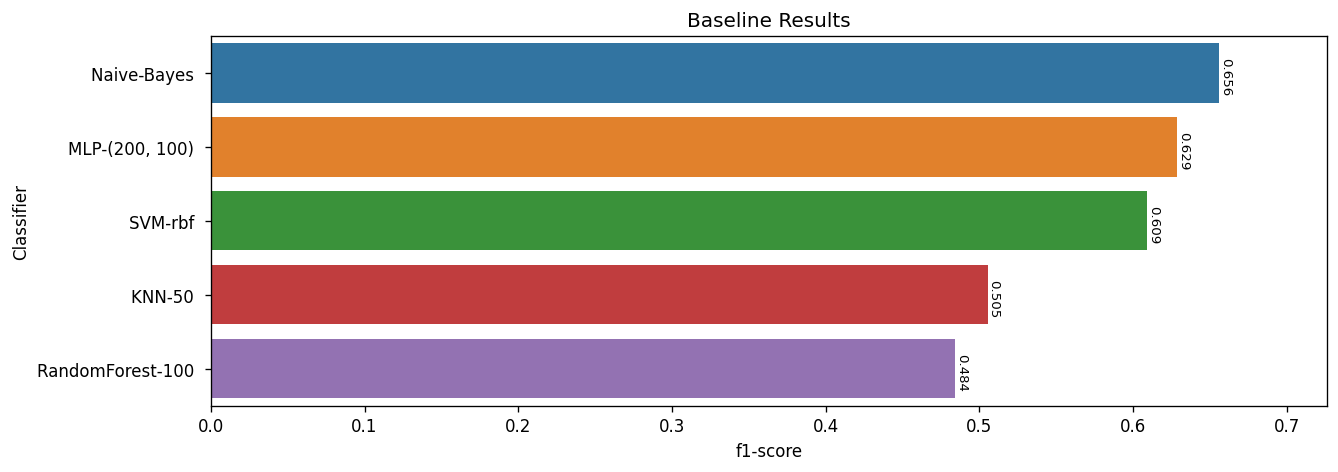

In [112]:
plot_results(baseline_results, 'f1-score', figsize=(12, 4))

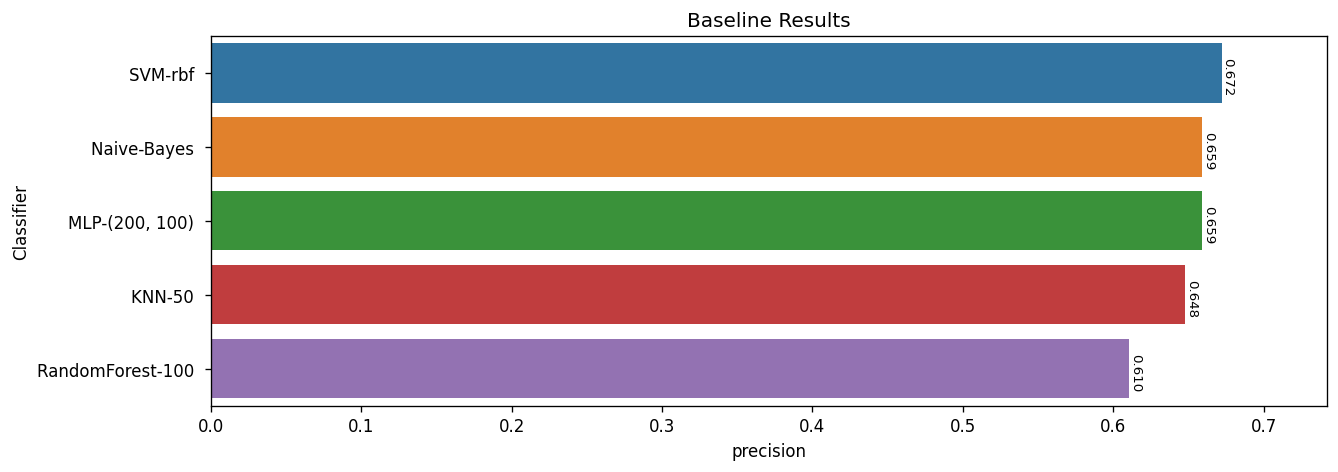

In [113]:
plot_results(baseline_results, 'precision',  figsize=(12, 4))

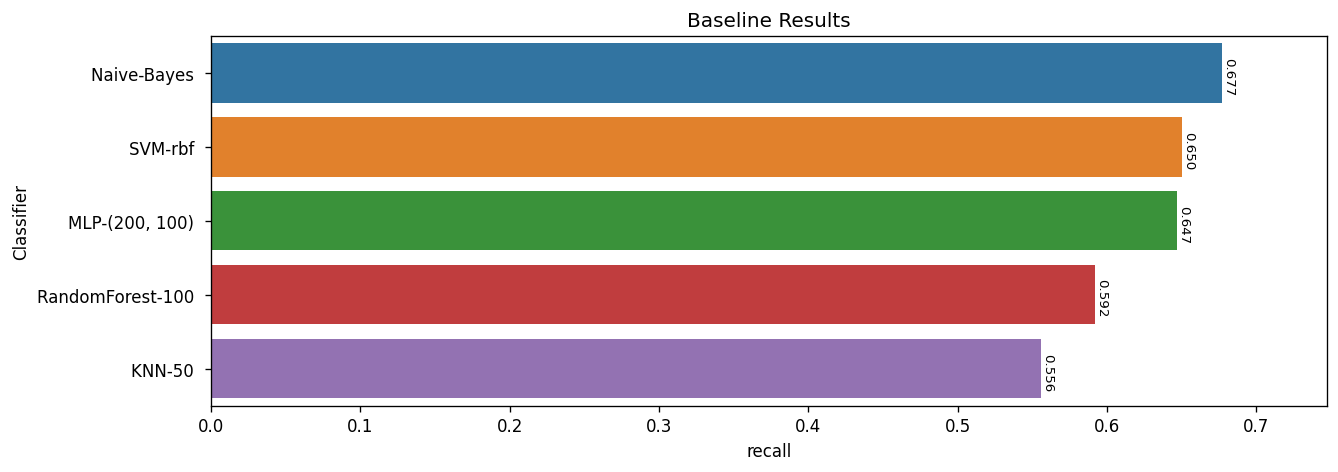

In [114]:
plot_results(baseline_results, 'recall',  figsize=(12, 4))

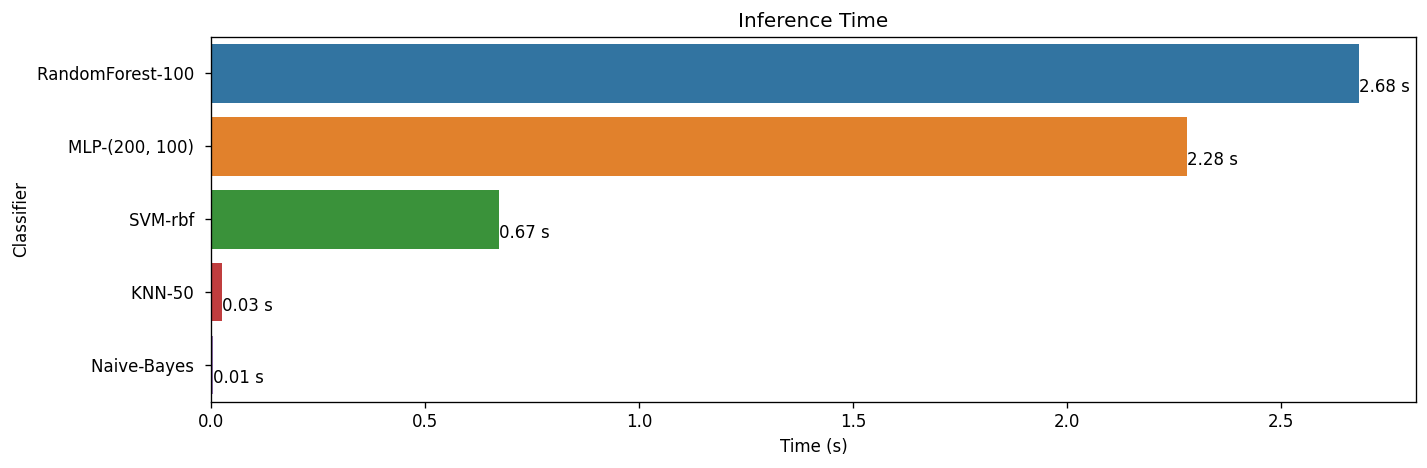

In [115]:
plot_inference_time(baseline_results, 'Inference Time', 'Time (s)', (12, 4))

In [161]:
# save baseline_results dict
with open('baseline_results_approach3_fever.pkl', 'wb') as f:
    pickle.dump(baseline_results, f)

## Proposed method

In [78]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

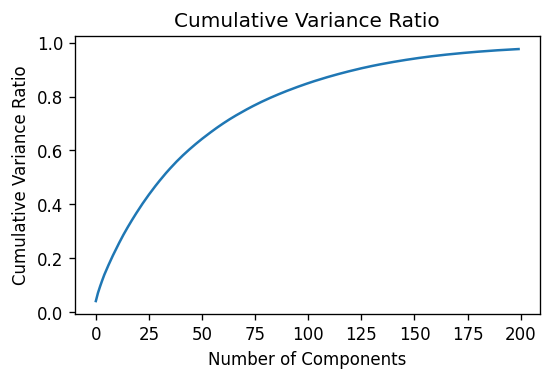

In [162]:
pca = PCA(n_components=200, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_dev_pca = pca.transform(X_dev)

plt.rcParams['figure.dpi'] = 120

# plot the cumulative variance ratio
plt.figure(figsize=(5, 3))
plt.title("Cumulative Variance Ratio")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Ratio")
plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.show()



In [163]:
proposed_results = {}
pca_components = [100]
for n in pca_components:
    pca = PCA(n_components=n, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    sizes[f'PCA-{n}'] = X_train_pca.nbytes
    X_dev_pca = pca.transform(X_dev)
    print(f"PCA with {n} components")
    run_classifiers(X_train_pca, y_train, X_dev_pca, y_dev, results=proposed_results, suffix=f'PCA-{n}', **configurations)


PCA with 100 components


In [164]:
# t-SNE
tsne_components = [50]
for n in tsne_components:
    tsne = TSNE(n_components=n, random_state=2000, method='exact')
    X_train_tsne = tsne.fit_transform(X_train[:1000])
    y_train_tsne = y_train[:1000]
    sizes[f't-SNE-{n}'] = X_train_tsne.nbytes
    X_dev_tsne = tsne.fit_transform(X_dev)
    print(f"t-SNE with {n} components")
    run_classifiers(X_train_tsne, y_train_tsne, X_dev_tsne, y_dev, results=proposed_results, suffix=f't-SNE-{n}', **configurations)


KeyboardInterrupt: 

In [ ]:
# ISOMAP

isomap = Isomap(n_components=50)
X_train_isomap = isomap.fit_transform(X_train)
X_dev_isomap = isomap.transform(X_dev)

run_classifiers(X_train_isomap, y_train, X_dev_isomap, y_dev, results=proposed_results, suffix=f'ISOMAP-50', **configurations)

/Users/behzadshomali/miniforge3/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Users/behzadshomali/miniforge3/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/behzadshomali/miniforge3/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/behzadshomali/miniforge3/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficie

{'SVM-rbf PCA-100': {'-1': {'precision': 0.5238095238095238,
   'recall': 0.859375,
   'f1-score': 0.6508875739644971,
   'support': 128},
  '0': {'precision': 0.7419354838709677,
   'recall': 0.27218934911242604,
   'f1-score': 0.3982683982683982,
   'support': 169},
  '1': {'precision': 0.7978142076502732,
   'recall': 0.8563049853372434,
   'f1-score': 0.8260254596888259,
   'support': 341},
  'accuracy': 0.7021943573667712,
  'macro avg': {'precision': 0.6878530717769217,
   'recall': 0.6626231114832232,
   'f1-score': 0.6250604773072405,
   'support': 638},
  'weighted avg': {'precision': 0.7280397502046329,
   'recall': 0.7021943573667712,
   'f1-score': 0.677579389543424,
   'support': 638},
  'infer_time': 0.3226938247680664},
 'MLP-(200, 100) PCA-100': {'-1': {'precision': 0.5133689839572193,
   'recall': 0.75,
   'f1-score': 0.6095238095238096,
   'support': 128},
  '0': {'precision': 0.6986301369863014,
   'recall': 0.30177514792899407,
   'f1-score': 0.42148760330578505,
  

In [166]:
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train, y_train)
sizes['LDA'] = X_train_lda.nbytes
X_dev_lda = lda.transform(X_dev)

run_classifiers(X_train_lda, y_train, X_dev_lda, y_dev, suffix='LDA', results=proposed_results, **configurations);

In [167]:
all_results = {**baseline_results, **proposed_results}

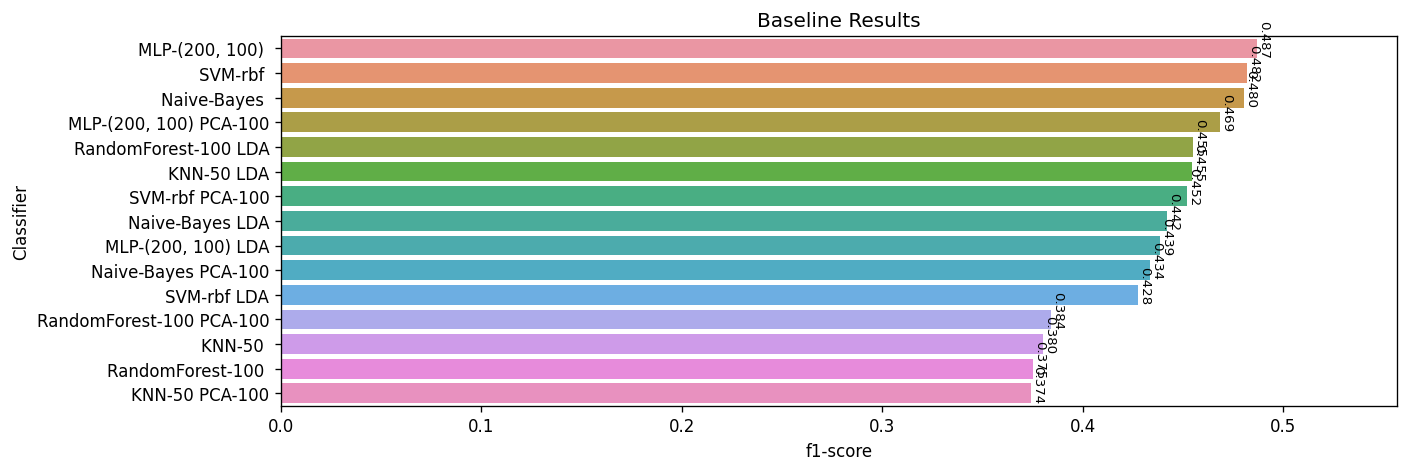

In [170]:
plot_results(all_results, 'f1-score', figsize=(12, 4), threshold=0.1)

In [98]:
# plot_results(all_results, 'precision', figsize=(10, 20), threshold=0.65)

In [99]:
# plot_results(all_results, 'recall', figsize=(10, 12), threshold=0.65)

In [91]:
all_results.keys()

dict_keys(['SVM-rbf ', 'MLP-(200, 100) ', 'RandomForest-100 ', 'KNN-50 ', 'Naive-Bayes ', 'SVM-rbf PCA-100', 'MLP-(200, 100) PCA-100', 'RandomForest-100 PCA-100', 'KNN-50 PCA-100', 'Naive-Bayes PCA-100', 'SVM-rbf t-SNE-50', 'MLP-(200, 100) t-SNE-50', 'RandomForest-100 t-SNE-50', 'KNN-50 t-SNE-50', 'Naive-Bayes t-SNE-50', 'SVM-rbf ISOMAP-50', 'MLP-(200, 100) ISOMAP-50', 'RandomForest-100 ISOMAP-50', 'KNN-50 ISOMAP-50', 'Naive-Bayes ISOMAP-50', 'SVM-rbf LDA', 'MLP-(200, 100) LDA', 'RandomForest-100 LDA', 'KNN-50 LDA', 'Naive-Bayes LDA'])

In [171]:
sizes

{'Original': 223409664,
 'PCA-100': 58179600,
 't-SNE-50': 200000,
 'LDA': 2327184}

/var/folders/32/40k3q1sj5bqc1ypsbt473gl00000gn/T/ipykernel_1546/1236351535.py:42: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


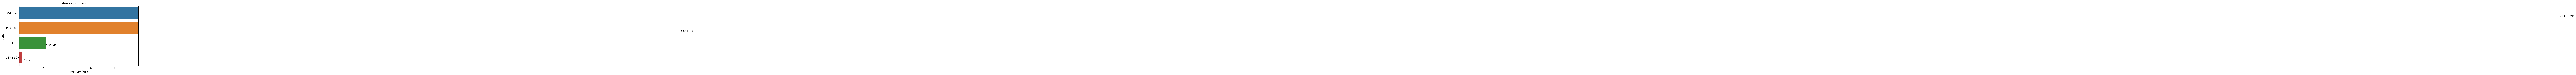

In [173]:
plot_sizes(sizes, 'Memory Consumption', 'Memory (MB)', figsize=(8, 4))

In [174]:
with open('proposed_results_approach3_fever.pkl', 'wb') as f:
    pickle.dump(proposed_results, f)

# save sizes
with open('sizes_approach3_fever.pkl', 'wb') as f:
    pickle.dump(sizes, f)

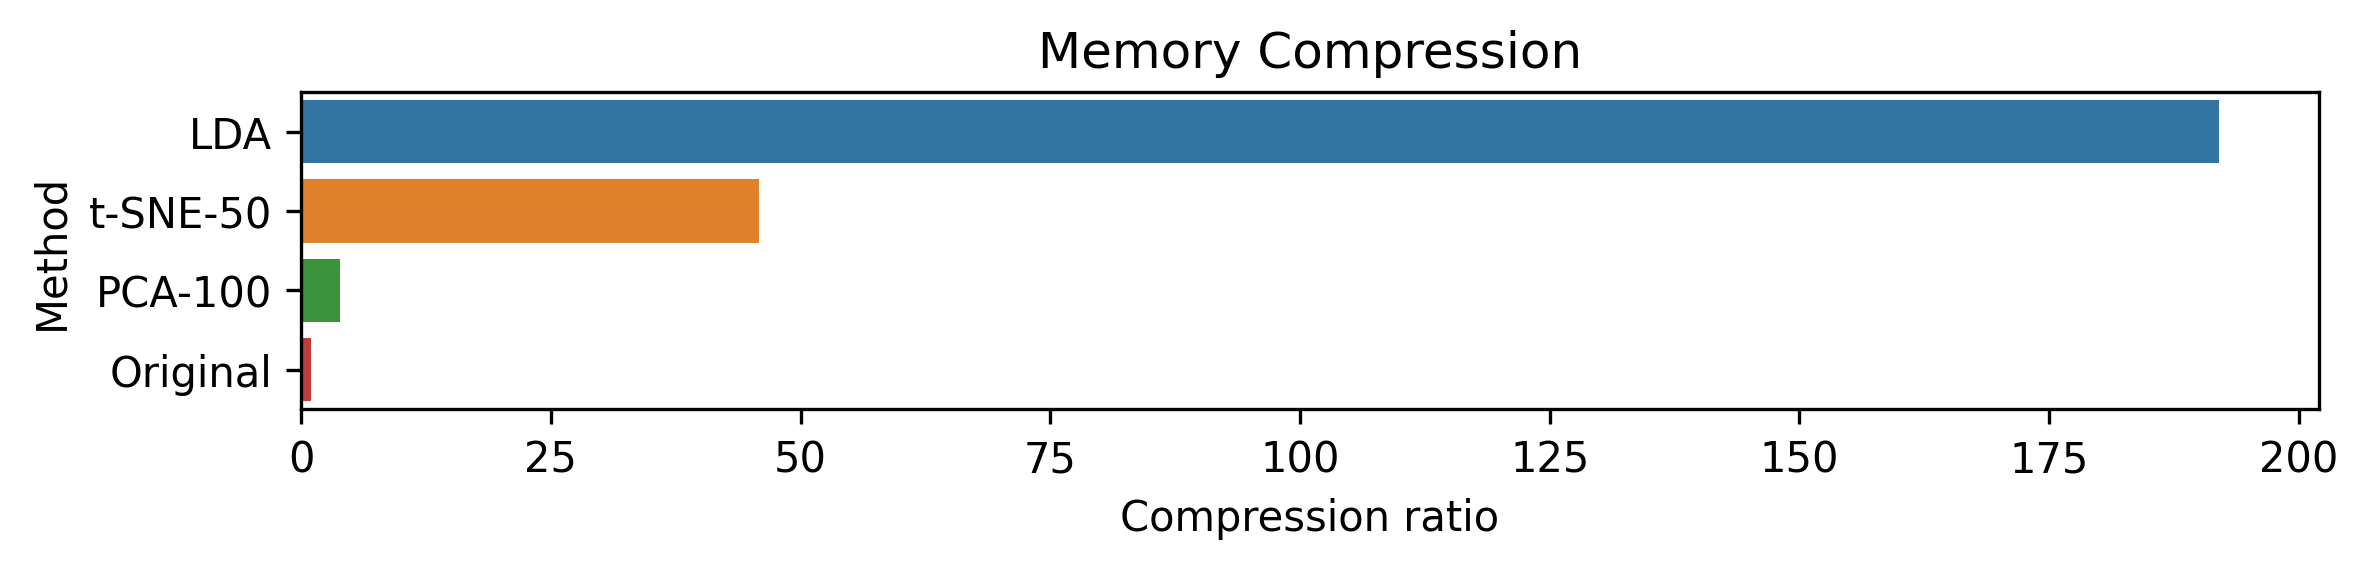

In [214]:
plot_sizes(
    compression_ratios,
    title='Memory Compression',
    xlabel='Compression ratio',
    figsize=(8, 2),
    is_ratio=True
)

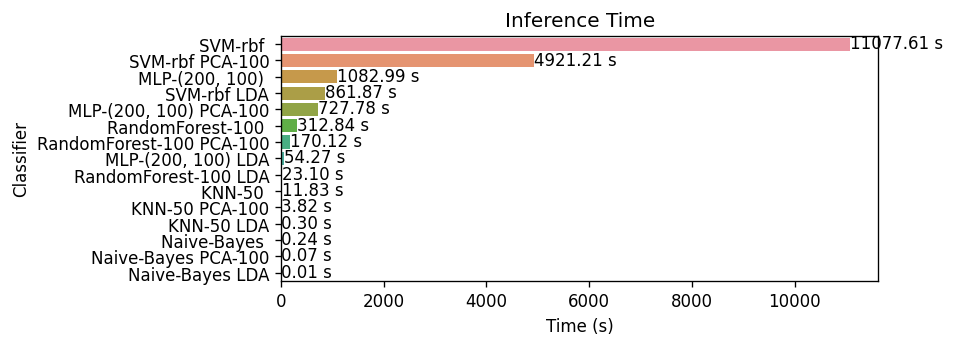

In [176]:
plot_inference_time(all_results, 'Inference Time', 'Time (s)', figsize=(8, 3))